<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Adversarial_attacks_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial attacks on MNIST

Today we're going to do 2 things: 
- Traine a naive CNN on MNIST
- Attack it with different techniques

Let's start!



In [1]:
# uncomment if not already installed  
#!pip install tensorboardX

In [2]:
# Imports + constants
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
from torchvision import datasets, transforms

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

import matplotlib.pyplot as plt

# Reproducibility 
# Notice that complete reproducibility is not guaranteed anyway 
# (for example due to the non perfect associativity of floating point addition)
# Look here for more : https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(42)
torch.manual_seed(42)

## MNIST classifier

### The architecture

In [3]:
class Net(nn.Module):
  """2 layers feed-forward classifier for MNIST images"""
  def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

  def forward(self, x):
      x = x.view((-1, 28*28))
      x = F.relu(self.fc(x))
      x = self.fc2(x)
      return x

In [4]:
class ConvNet(nn.Module):
  """Pretty basic CNN classifier for MNIST images."""
  def __init__(self):
      # We'll use 6 convolutional layers with decreasing convolution window 
      # and increasing number of channels 
      # + ReLU after each layer 
      # + batch normalization
      # + dropout and 2 fully connected layers as a classification head 
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5))
      self.bn1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 32, kernel_size=(5, 5))
      self.bn2 = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
      self.bn3 = nn.BatchNorm2d(64)
      self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
      self.bn4 = nn.BatchNorm2d(64)
      self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3))
      self.bn5 = nn.BatchNorm2d(128)
      self.conv6 = nn.Conv2d(128, 128, kernel_size=(1, 1))
      self.bn6 = nn.BatchNorm2d(128)
      self.conv2_drop = nn.Dropout2d(p=0.2)
      self.fc1 = nn.Linear(128, 100)
      self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
      ##  CONVOLUTIONAL LAYERS 
      x = F.relu(self.conv1(x))
      x = self.bn1(x)
      x = F.relu(self.conv2(x))
      x = self.conv2_drop(F.max_pool2d(self.bn2(x), 2))
      x = F.relu(self.conv3(x))
      x = self.bn3(x)
      x = F.relu(self.conv4(x))
      x = self.bn4(x)
      x = F.max_pool2d(x, 2)
      x = self.conv2_drop(x)
      x = F.relu(self.conv5(x))
      x = self.bn5(x)
      x = F.relu(self.conv6(x))
      x = self.bn6(x)
      ## CLASSIFICATION HEAD 
      size = x.size()[1] * x.size()[2] * x.size()[3]
      # flattening 
      x = x.view(-1, size)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x


### The data 

In [ ]:
# Here do 2 things: 
# 1. Download the MNIST dataset (already divided into train and test)
# 2. normalize the input s.t. we have a certain mean and sd (note that the provided
# mean and sd are the empirical ones from the data)
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, 
                               transform=transforms.Compose([transforms.ToTensor(), 
                                                             transforms.Normalize((0.1307,), (0.3081,))]))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, 
                              transform=transforms.Compose([transforms.ToTensor(), 
                                                            transforms.Normalize((0.1307,), (0.3081,))]))

In [6]:
# Use a DataLoader to avoid iterating through the data yourself
# Notice the batch_size=64 that we defined above 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training 

In [ ]:
# (This has any effect only if the model is not already there)
ff_model = Net().to(device)
conv_model = ConvNet().to(device)

#This has any effect only on certain modules
# (e.g. Dropout, BatchNorm) which behave differently 
# in train and test mode.
ff_model.train()
conv_model.train()

In [9]:
learning_rate = 0.0001
num_epochs = 5
# Optimizers:
""" SGD vs Adam """
#opt = optim.SGD(params=model.parameters(), lr=learning_rate)
opt = optim.Adam(params=conv_model.parameters(), lr=learning_rate)
# Loss: 
ce_loss = torch.nn.CrossEntropyLoss()

In [11]:
tot_steps = 0
for epoch in range(1,num_epochs+1):
  print("-------------- Epoch "+str(epoch)+" -------------")
  t1 = time.time()
  for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    tot_steps += 1
    opt.zero_grad()
    out = conv_model(x_batch)
    batch_loss = ce_loss(out, y_batch)

    # show accuracy every 100 steps
    if batch_idx % 100 == 0:
      pred = torch.max(out, dim=1)[1] # predictions
      acc = pred.eq(y_batch).sum().item() / float(batch_size) # accuracy
      print("Batch "+str(batch_idx)+": "+ str(acc))

    batch_loss.backward()
    opt.step() 
  t2 = time.time()
  print("Time = %.2lf seconds"%(t2-t1))

-------------- Epoch 1 -------------
Batch 0: 0.078125
Batch 100: 0.78125
Batch 200: 0.90625
Batch 300: 0.96875
Batch 400: 0.96875
Batch 500: 0.9375
Batch 600: 0.96875
Batch 700: 0.953125
Batch 800: 1.0
Batch 900: 0.984375
Time = 163.63 seconds
-------------- Epoch 2 -------------
Batch 0: 1.0
Batch 100: 0.96875
Batch 200: 0.9375
Batch 300: 0.984375
Batch 400: 1.0
Batch 500: 0.984375
Batch 600: 0.96875
Batch 700: 1.0
Batch 800: 0.96875
Batch 900: 1.0
Time = 162.66 seconds
-------------- Epoch 3 -------------
Batch 0: 0.984375
Batch 100: 1.0
Batch 200: 0.953125
Batch 300: 1.0
Batch 400: 0.96875
Batch 500: 0.953125
Batch 600: 0.9375
Batch 700: 1.0
Batch 800: 0.984375
Batch 900: 1.0
Time = 162.59 seconds
-------------- Epoch 4 -------------
Batch 0: 0.984375
Batch 100: 0.96875
Batch 200: 0.984375
Batch 300: 1.0
Batch 400: 0.984375
Batch 500: 0.953125
Batch 600: 0.96875
Batch 700: 0.984375
Batch 800: 0.984375
Batch 900: 1.0
Time = 162.23 seconds
-------------- Epoch 5 -------------
Batch 0

In [12]:
# Evaluate on the test set 
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    out = conv_model(x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += x_batch.size()[0]
acc = tot_acc/tot_test
print('Accuracy %.5lf'%(acc))

Accuracy 0.98860


Here I'll save the result of some trials:

    1) Net + Adam x 5 epochs = 0.9575 test accuracy / time x epoch around 11 s
    2) ConvNet + Adam x 5 epochs = 0.98870 test accuracy/ time x epoch around 170 s

Notice that this result are obtained by training on CPU

## Attacks

In [13]:
# decide which model to try your attacks on
model = conv_model

In [ ]:
# We first load the test dataset again. 
# Notice that this time we don't want to normalize the input right away 
# (as we want to be able to search for adversarial examples in the original 
# image domain)
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, 
                              transform=transforms.Compose([transforms.ToTensor()]))
# In order to be able for our trained model to function with this un-normalized
# input we need to insert a normalization layer first 
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081
model = nn.Sequential(Normalize(), model)
# and here we also create a version of the model that outputs the class probabilities
model_to_prob = nn.Sequential(model, nn.Softmax())
# we put the neural net into evaluation mode (this disables features like dropout)
model.eval()
model_to_prob.eval()

#### The attacks 
We're now going to implement 4 different attacks (actually 2, each one of them in its targeted and untargeted version). 

1) **FGSM** : fast gradient sign method. One shot algorithm, meaning that the output is obtained in only one step. 

2) **PGD** : projected gradient descent (method) - an iterative evolution of the previous one


In [32]:
def fgsm(model, x, lbl, eps, targeted=True):
    """ Implementing both targeted and untargeted FGSM algorithm."""

    # detatch the input from the graph of previous computation 
    input_ = x.clone().detach_()
    # tell pytorch to track the gradients wrt input x
    input_.requires_grad_()
    # loss here 
    loss = ce_loss(model(input_), torch.tensor([lbl], dtype=torch.long))
    # gradient of the loss 
    loss.backward() 
    # now comes the difference in logic between targeted and untargeted attacks
    
    # The idea here is to minimise the model's loss 
    # with respect to the target label 
    if targeted: x_adv = input_ - eps*torch.sign(input_.grad)
    # The idea here is to maximise the model's loss wrt 
    # the original label ('label')
    else: x_adv = input_ + eps*torch.sign(input_.grad)

    return x_adv


def pgd(model, x, lbl, k, eps, eps_step, targeted=True, clipping=True):
    # The idea here is to search for adversarial example 
    # inside a ball around the original example x 
    # As projection is easier in this case, we use an L-infinity 
    # ball of radius eps 
    # if clipping is set to True we restrict the outputs to 
    # the [0,1]^n box if clipping is set to True

    # random initialization 
    eta = torch.rand_like(x)*2*eps - eps
    x_adv = x + eta
    # iteration 
    for steps in range(1,k+1):
      # computing fgsm step 
      next_x = fgsm(model, x_adv, lbl, eps_step, targeted=targeted)

      # projecting the step into the ball 
      delta = next_x - x
      delta = torch.clamp(delta, min=-1*eps, max=eps)  

      # taking the step    
      x_adv = x + delta

      if clipping: 
        # projecting the output to the [0,1] box
        x_adv = torch.clamp(x_adv, min=0, max=1)

      # check if we have an adversarial example 
      out = model(x_adv)
      pred = torch.max(out, dim=1)
      if pred==lbl and targeted: return x_adv
      if pred!=lbl and not targeted: return x_adv

    return x_adv


In [33]:
# define a show function that displays the original image together with the 
# adversarial example and the model predictions
def show(original, adv, model_to_prob):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[0].set_title("Original, class: " + str(p0.argmax()))
    axarr[1].imshow(adv.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[1].set_title("Adversarial, class: " + str(p1.argmax()))

Trying out attacks! 

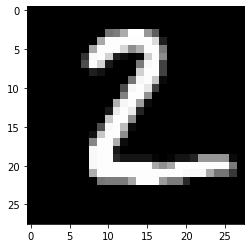

In [47]:
original = torch.unsqueeze(test_dataset[1][0], dim=0)
f, axarr = plt.subplots(1,1)
axarr.imshow(original[0][0], cmap='gray')

In [ ]:
# try out our attacks
original = torch.unsqueeze(test_dataset[0][0], dim=0)
adv = fgsm(model, original, lbl=, eps=0.08, targeted=True)
show(original, adv, model_to_prob)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


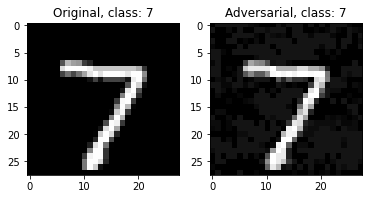

In [34]:
# try out our attacks
original = torch.unsqueeze(test_dataset[0][0], dim=0)
adv = pgd(model, original, lbl=, k=100, eps=0.08, eps_step=0.05, targeted=True)
show(original, adv, model_to_prob)